In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook',ticks=True, grid=False)
import warnings
warnings.filterwarnings('ignore')
#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
#feature engineering
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
#evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report, plot_precision_recall_curve, plot_roc_curve
#saving models
import pickle

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Metrics Selection
    
    TP : If the model predict stroke, and actual is stroke : early treatment to prevent stroke
    TN : If the model predict false stroke, and actual is false stroke : safe
    FP : If the model predict stroke, but actual is false stroke : panic
    FN : If the model predict false stroke, but actual is stroke : stroke because not getting 
    an early treatment
    
Here I want to focus more on preveting FN, which means I will be using Recall

In [3]:
round(df.isna().sum()/len(df.index)*100, 2)

id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

In [4]:
df.drop(['id'], axis = 1, inplace = True)

In [5]:
df.drop(df.loc[df['gender']=='Other'].index, inplace=True)

In [6]:
x = df.drop(['stroke'], axis = 1)
y = df['stroke']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 2021)

# Model Selection

    DecisionTree
    Logistric Regression
    KNN

    I will be making 2 different transformer base on the way I fill the missing values in BMI 
    which will be mean and median

# Data Preprocessing

In [8]:
one_hot = OneHotEncoder(drop = 'first')
binary = BinaryEncoder()
imputer_mean = SimpleImputer(strategy = 'mean')
imputer_medi = SimpleImputer(strategy = 'median')

#MEAN IMPUTER
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', imputer_mean, ['bmi'])
], remainder = 'passthrough')

#MEDIAN IMPUTER
transformer_medi = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', imputer_medi, ['bmi'])
], remainder = 'passthrough')

# SETUP MODELS(DEFAULT)

In [9]:
logreg = LogisticRegression(solver = 'liblinear')
tree = DecisionTreeClassifier(random_state = 2021)
knn = KNeighborsClassifier()

# TEST MODEL WITH MEAN IMPUTER

In [10]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1458
           1       0.14      0.17      0.15        75

    accuracy                           0.91      1533
   macro avg       0.55      0.56      0.55      1533
weighted avg       0.92      0.91      0.91      1533



In [11]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.07      0.01      0.02        75

    accuracy                           0.94      1533
   macro avg       0.51      0.50      0.50      1533
weighted avg       0.91      0.94      0.92      1533



In [12]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



# TEST MODEL WITH MEDIAN

In [13]:
estimatortree = Pipeline([
    ('transformer', transformer_medi),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1458
           1       0.15      0.19      0.17        75

    accuracy                           0.91      1533
   macro avg       0.55      0.57      0.56      1533
weighted avg       0.92      0.91      0.91      1533



In [14]:
estimatorknn = Pipeline([
    ('transformer', transformer_medi),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.07      0.01      0.02        75

    accuracy                           0.94      1533
   macro avg       0.51      0.50      0.50      1533
weighted avg       0.91      0.94      0.92      1533



In [15]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_medi),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



# CROSSVALIDATE MEAN AND MEDIAN TO SEE WHICH IS BETTER

CROSSVALIDATE MEAN FUNCTION

In [16]:
def model_evaluation_cv_mean(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

CROSSVALIDATE MEDIAN FUNCTION

In [17]:
def model_evaluation_cv_medi(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_medi),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [18]:
def print_result(model_cv):
    print('score : ', model_cv)
    print('mean score : ', model_cv.mean())
    print('std score : ', model_cv.std())

CROSSVALIDATE TREE WITH MEDIAN AND MEAN

In [19]:
model_cv = model_evaluation_cv_mean(tree)
print_result(model_cv)

score :  [0.22857143 0.26470588 0.17142857 0.11428571 0.17142857]
mean score :  0.19008403361344542
std score :  0.0519444657909256


In [20]:
model_cv = model_evaluation_cv_medi(tree)
print_result(model_cv)

score :  [0.22857143 0.17647059 0.2        0.11428571 0.17142857]
mean score :  0.17815126050420171
std score :  0.0378057878292504


CROSSVALIDATE KNN WITH MEAN AND MEDIAN

In [21]:
model_cv = model_evaluation_cv_mean(knn)
print_result(model_cv)

score :  [0.         0.02941176 0.02857143 0.         0.05714286]
mean score :  0.023025210084033614
std score :  0.021428406656146863


In [22]:
model_cv = model_evaluation_cv_medi(knn)
print_result(model_cv)

score :  [0.         0.         0.         0.         0.05714286]
mean score :  0.011428571428571429
std score :  0.022857142857142857


CROSSVALIDATE LOGREG WITH MEDIAN AND MEAN

In [23]:
model_cv = model_evaluation_cv_mean(logreg)
print_result(model_cv)

score :  [0. 0. 0. 0. 0.]
mean score :  0.0
std score :  0.0


In [24]:
model_cv = model_evaluation_cv_medi(logreg)
print_result(model_cv)

score :  [0. 0. 0. 0. 0.]
mean score :  0.0
std score :  0.0


# Conclusion for which imputer suits best? Median or Mean

    Impute the missing values by Mean is better than Median. Eventhough the data is pretty skewed which mean
    I should be using median instead, but as a performance, using Mean is much better than Median, and so
    I will be using Mean.

# Resampling
    
    The difference(in quantity) between target 1 and 0 is quite huge. 
    And that might be the reason why the model performance is really low
    Target 1 : 1458 and Target 0 : 75. Split-test : 0.3
    Which is why resampling is needed

# List of resampling method

In [25]:
randomover = RandomOverSampler(random_state = 2021)
randomunder = RandomUnderSampler(random_state = 2021)
smote = SMOTE(random_state = 2021)
nearmiss = NearMiss()

Crossvalidate using Random Over Function

In [26]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomover),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

Crossvalidate using Random Under Function

In [27]:
def model_evaluation_cv_mean_under(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomunder),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

Crossvalidate using SMOTE Function

In [28]:
def model_evaluation_cv_mean_smote(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', smote),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

Crossvalidate using NEARMISS Function

In [29]:
def model_evaluation_cv_mean_near(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', nearmiss),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

# RESAMPLING RESULT FOR TREE

In [30]:
model_cv = model_evaluation_cv_mean_over(tree)
print_result(model_cv)

score :  [0.08571429 0.26470588 0.02857143 0.11428571 0.05714286]
mean score :  0.11008403361344536
std score :  0.08242151149740658


In [31]:
model_cv = model_evaluation_cv_mean_under(tree)
print_result(model_cv)

score :  [0.65714286 0.55882353 0.71428571 0.71428571 0.77142857]
mean score :  0.6831932773109244
std score :  0.07192413362081414


In [32]:
model_cv = model_evaluation_cv_mean_smote(tree)
print_result(model_cv)

score :  [0.2        0.17647059 0.11428571 0.11428571 0.2       ]
mean score :  0.16100840336134453
std score :  0.03910444406165481


In [33]:
model_cv = model_evaluation_cv_mean_near(tree)
print_result(model_cv)

score :  [0.74285714 0.79411765 0.74285714 0.68571429 0.77142857]
mean score :  0.7473949579831933
std score :  0.036349176368882644


BEST SCORE GOES TO NEARMISS SCORE : 0.7473

# RESAMPLING RESULT FOR LOGREG

In [34]:
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.71428571 0.79411765 0.68571429 0.88571429 0.82857143]
mean score :  0.7816806722689076
std score :  0.07338670425214266


In [35]:
model_cv = model_evaluation_cv_mean_under(logreg)
print_result(model_cv)

score :  [0.77142857 0.76470588 0.74285714 0.8        0.77142857]
mean score :  0.7700840336134454
std score :  0.018269147215732705


In [36]:
model_cv = model_evaluation_cv_mean_smote(logreg)
print_result(model_cv)

score :  [0.74285714 0.79411765 0.68571429 0.88571429 0.82857143]
mean score :  0.7873949579831934
std score :  0.06889116427128314


In [37]:
model_cv = model_evaluation_cv_mean_near(logreg)
print_result(model_cv)

score :  [0.6        0.70588235 0.51428571 0.6        0.54285714]
mean score :  0.5926050420168066
std score :  0.06565042352407652


BEST SCORE GOES TO SMOTE : 0.7873

# RESAMPLING RESULT FOR KNN

In [38]:
model_cv = model_evaluation_cv_mean_over(knn)
print_result(model_cv)

score :  [0.37142857 0.32352941 0.31428571 0.42857143 0.31428571]
mean score :  0.35042016806722687
std score :  0.04446005579143296


In [39]:
model_cv = model_evaluation_cv_mean_under(knn)
print_result(model_cv)

score :  [0.8        0.85294118 0.8        0.82857143 0.82857143]
mean score :  0.8220168067226892
std score :  0.020058526047510152


In [40]:
model_cv = model_evaluation_cv_mean_smote(knn)
print_result(model_cv)

score :  [0.45714286 0.47058824 0.57142857 0.57142857 0.45714286]
mean score :  0.5055462184873949
std score :  0.05401629425640515


In [41]:
model_cv = model_evaluation_cv_mean_near(knn)
print_result(model_cv)

score :  [0.51428571 0.70588235 0.48571429 0.62857143 0.65714286]
mean score :  0.5983193277310924
std score :  0.084482832914563


BEST SCORE GOES TO randomunder : 0.8220

# QUICK FUNCTION FOR CROSSVALIDATE OVERALL MODELS

In [42]:
def model_evaluation_cv_mean_overall():
    model_test = [logreg, tree, knn]
    imbalance_method = [randomunder, randomover, smote, nearmiss]
    imbalance_method_name = ['randomunder', 'randomover', 'smote', 'nearmiss']
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', transformer_mean),
            ('balancing', imbalance_method[i]),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison

model_evaluation_cv_mean_overall()            

,Model,randomunder,randomover,smote,nearmiss
0,logreg,0.77,0.78,0.79,0.59
1,tree,0.68,0.11,0.16,0.75
2,knn,0.82,0.35,0.51,0.60


# DETAILS #1

    TREE BEST : nearmiss(0.747) WORST : randomover(0.110)
    LOGREG BEST : smote(0.787) WORST : nearmiss(0.592)
    KNN BEST : randomunder(0.822) WORST : randomover(0.350)

# DETAILS #2

    RandomOverSampler = Best : Logreg(mean score :  0.781, std score :  0.073)
    RandomUnderSampler = Best : KNN(mean score :  0.822, std score :  0.020)
    SMOTE = Best : Logreg(mean score :  0.787, std score :  0.068)
    NearMiss = Best : Tree(mean score :  0.747, std score :  0.036)

# PREDICT TEST FOR EACH MODELS

# RANDOM OVER

In [43]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomover),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.88      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.79      0.53      1533
weighted avg       0.95      0.72      0.80      1533



In [44]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomover),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1458
           1       0.17      0.17      0.17        75

    accuracy                           0.92      1533
   macro avg       0.57      0.57      0.57      1533
weighted avg       0.92      0.92      0.92      1533



In [45]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomover),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1458
           1       0.13      0.37      0.19        75

    accuracy                           0.85      1533
   macro avg       0.55      0.62      0.55      1533
weighted avg       0.92      0.85      0.88      1533



BEST MODEL WOULD BE : logreg(0.88), WORST : TREE(0.18)

# Random Under

In [46]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomunder),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.85      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.78      0.53      1533
weighted avg       0.95      0.72      0.80      1533



In [47]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomunder),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1458
           1       0.10      0.73      0.18        75

    accuracy                           0.68      1533
   macro avg       0.54      0.70      0.49      1533
weighted avg       0.94      0.68      0.77      1533



In [48]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomunder),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78      1458
           1       0.11      0.85      0.20        75

    accuracy                           0.66      1533
   macro avg       0.55      0.75      0.49      1533
weighted avg       0.95      0.66      0.75      1533



BEST MODEL WOULD BE : LOGREG AND KNN(0.88) WORST : TREE(0.73)

# SMOTE

In [49]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', smote),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1458
           1       0.13      0.83      0.23        75

    accuracy                           0.73      1533
   macro avg       0.56      0.78      0.53      1533
weighted avg       0.95      0.73      0.81      1533



In [50]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', smote),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1458
           1       0.09      0.12      0.11        75

    accuracy                           0.90      1533
   macro avg       0.52      0.53      0.53      1533
weighted avg       0.91      0.90      0.91      1533



In [51]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', smote),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1458
           1       0.12      0.59      0.20        75

    accuracy                           0.77      1533
   macro avg       0.55      0.68      0.53      1533
weighted avg       0.93      0.77      0.84      1533



BEST MODEL WOULD BE : LOGREG(0.83) WORST : TREE(0.12)

# Near Miss

In [52]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', nearmiss),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.29      0.44      1458
           1       0.04      0.63      0.08        75

    accuracy                           0.30      1533
   macro avg       0.49      0.46      0.26      1533
weighted avg       0.89      0.30      0.42      1533



In [53]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', nearmiss),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.21      0.35      1458
           1       0.04      0.68      0.08        75

    accuracy                           0.24      1533
   macro avg       0.49      0.45      0.21      1533
weighted avg       0.89      0.24      0.33      1533



In [54]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', nearmiss),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.24      0.38      1458
           1       0.04      0.63      0.08        75

    accuracy                           0.26      1533
   macro avg       0.48      0.43      0.23      1533
weighted avg       0.88      0.26      0.36      1533



BEST WOULD BE : TREE(0.68) WORST : LOGREG AND KNN(0.63)

# QUICK FUNCTION FOR PREDICT TEST OVERALL MODELS

In [55]:
def overall_func():
    model_test = [logreg, tree, knn]
    imbalance_method = [randomunder, randomover, smote, nearmiss]
    imbalance_method_name = ['randomunder', 'randomover', 'smote', 'nearmiss']
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
                ('transformer', transformer_mean),
                ('balancing', imbalance_method[i]),
                ('model', model_test[j])])
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)
            temp_list.append(round(recall_score(y_test, y_pred),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison
overall_func()

,Model,randomunder,randomover,smote,nearmiss
0,logreg,0.85,0.88,0.83,0.63
1,tree,0.73,0.17,0.12,0.68
2,knn,0.85,0.37,0.59,0.63


# MODEL PERFORMANCE CROSSVALIDATE -> PREDICT TEST

    
    RANDOM UNDER :
        logreg : 0.77 -> 0.85 difference +(0.08)
        tree : 0.68 -> 0.73 difference +(0.06)
        knn : 0.82 -> 0.85 difference +(0.03)
    RANDOM OVER :
        logreg : 0.78 -> 0.88 difference +(0.1)
        tree : 0.11 -> 0.17 difference +(0.06)
        knn : 0.35 -> 0.37 difference +(0.02)
    SMOTE :
        logreg : 0.77 -> 0.83 difference +(0.05)
        tree : 0.16 -> 0.12 difference -(0.04)
        knn : 0.51 -> 0.59 difference +(0.08)
    NEARMISS :
        logreg : 0.59 -> 0.63 difference +(0.04)
        tree : 0.75 -> 0.68 difference -(0.07)
        knn : 0.60 -> 0.63 difference +(0.03)
        
# Overall Best among the rest goes to Random Over Logreg with score of 0.88

# Models that I will pick for further improvement
    
    Random Under : Logreg, KNN
    Random Over : Logreg
    SMOTE : Logreg
    Nearmiss : Tree(UNDERFITTING), I will not be using this

<AxesSubplot:xlabel='bmi'>

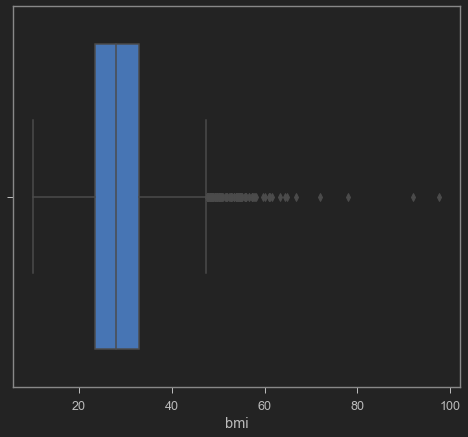

In [56]:
sns.boxplot(data = df, x = df['bmi'])

<AxesSubplot:xlabel='avg_glucose_level'>

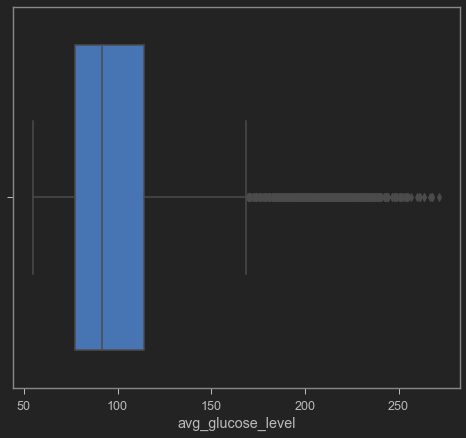

In [57]:
sns.boxplot(data = df, x = df['avg_glucose_level'])

# SCALING

    Robust, reasons : BMI and AVG glucose contains outliers
    MinMaxScaler : For KNN only

RANDOM UNDER : KNN scaled by MINMAX Scaler

In [58]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', MinMaxScaler())
])
transformer_mean_knn_minmax = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [59]:
def model_evaluation_cv_mean_under(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean_knn_minmax),
    ('balancing', randomunder),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [60]:
model_cv = model_evaluation_cv_mean_under(knn)
print_result(model_cv)

score :  [0.77142857 0.91176471 0.82857143 0.65714286 0.74285714]
mean score :  0.7823529411764706
std score :  0.08513563120614413


In [61]:
estimatorknnminmax = Pipeline([
    ('transformer', transformer_mean_knn_minmax),
    ('balancing', randomunder),
    ('model', knn)])
estimatorknnminmax.fit(x_train, y_train)
y_pred = estimatorknnminmax.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.83      0.22        75

    accuracy                           0.72      1533
   macro avg       0.56      0.77      0.52      1533
weighted avg       0.95      0.72      0.80      1533



# Scaling MinMax untuk RandomUnder KNN Menurun

    Dari 0.82(Crossvalidasi) - > 0.85(Test Predict) menjadi 
    0.78(Crossvalidasi) - > 0.83(Test Predict)

# Scaling Robust untuk Logreg Random Under, Random Over dan SMOTE

In [62]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', RobustScaler())
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [63]:
def model_evaluation_cv_mean_overall_logreg():
    model_test = [logreg]
    imbalance_method = [randomunder, randomover, smote]
    imbalance_method_name = ['randomunder', 'randomover', 'smote']
    data_comparison = pd.DataFrame({'Model' : ['logreg']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', transformer_mean_logreg),
            ('balancing', imbalance_method[i]),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison

model_evaluation_cv_mean_overall_logreg()            

,Model,randomunder,randomover,smote
0,logreg,0.81,0.79,0.79


In [64]:
def overall_func_logreg():
    model_test = [logreg]
    imbalance_method = [randomunder, randomover, smote]
    imbalance_method_name = ['randomunder', 'randomover', 'smote']
    data_comparison = pd.DataFrame({'Model' : ['logreg']})
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
                ('transformer', transformer_mean_logreg),
                ('balancing', imbalance_method[i]),
                ('model', model_test[j])])
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)
            temp_list.append(round(recall_score(y_test, y_pred),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison
overall_func_logreg()

,Model,randomunder,randomover,smote
0,logreg,0.87,0.87,0.84


# LOGREG PERFORMANCE AFTER SCALING BASED ON RESAMPLING METHOD

    RANDOM UNDER : 0.81 -> 0.87 +(0.06)
    RANDOM OVER :  0.79 -> 0.87 +(0.08)
    SMOTE : 0.79 - > 0.84 +(0.05)
    
# DIFFERENCE BETWEEN BEFORE AND AFTER SCALING PERFORMANCE BASED ON PREDICT TEST RESULT

    RANDOMUNDER : 0.85 -> 0.87 difference +(0.02)
    RANDOMOVER : 0.88 -> 0.87 difference -(0.01)
    SMOTE : 0.83 -> 0.84 difference +(0.01)

# Research so far :
    
    Logreg with scaling : Randomunder and Smote
    Logreg without scaling : Randomover
    KNN without scaling : Randomunder
    Tree without scaling : Nearmiss

# Last test for model improvement before Hyperparameter Tuning : Polynomial on LogReg

In [65]:
poly_scale = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Poly', PolynomialFeatures(degree = 1, interaction_only = False, include_bias = False)),
    ('Scaling', RobustScaler())
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Polynomial then Robust', poly_scale, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [66]:
def model_evaluation_cv_mean_overall_logreg():
    model_test = [logreg]
    imbalance_method = [randomunder, randomover, smote]
    imbalance_method_name = ['randomunder', 'randomover', 'smote']
    data_comparison = pd.DataFrame({'Model' : ['logreg']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', transformer_mean_logreg),
            ('balancing', imbalance_method[i]),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),3))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison    
model_evaluation_cv_mean_overall_logreg()

,Model,randomunder,randomover,smote
0,logreg,0.811,0.788,0.788


    Degree 1		0.811	0.788	0.788
    Degree 2		0.828	0.793	0.799
    Degree 3		0.822	0.782	0.793
    Degree 4		0.822	0.799	0.799
    Degree 5		0.816	0.799	0.793
    Degree 6		0.793	0.799	0.799
    Degree 7		0.793	0.782	0.787
    Degree 8		0.793	0.793	0.799
    Degree 9		0.793	0.793	0.799
    Degree 10		0.787	0.793	0.804

In [67]:
def overall_func_logreg():
    model_test = [logreg]
    imbalance_method = [randomunder, randomover, smote]
    imbalance_method_name = ['randomunder', 'randomover', 'smote']
    data_comparison = pd.DataFrame({'Model' : ['logreg']})
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
                ('transformer', transformer_mean_logreg),
                ('balancing', imbalance_method[i]),
                ('model', model_test[j])])
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)
            temp_list.append(round(recall_score(y_test, y_pred),3))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison
overall_func_logreg()

,Model,randomunder,randomover,smote
0,logreg,0.867,0.867,0.84


    Degree 1		0.87	0.87	0.84
    Degree 2		0.81	0.83	0.80
    Degree 3    	0.80    0.81	0.80
    Degree 4		0.79	0.81	0.79
    Degree 5		0.77	0.79	0.77
    Degree 6		0.79	0.80    0.77
    Degree 7		0.80    0.81	0.79
    Degree 8		0.81	0.80    0.79
    Degree 9		0.81	0.80    0.77
    Degree 10		0.80    0.81	0.77

# BEST DEGREE OVERALL GOES TO DEGREE 1

    But because the performance is not as good as(no significant improvement) 
    without using polynomial, I won't be using it

# What do we learn so far

    Scaling that does improvement for LogReg would be RandomUnder and Smote
    Without Improvement for LogReg goes to Random Over, KNN for Random Under
    Polynomial doesn't do any significant improvement for LogReg, so it won't be use later on
    MinMaxScaler doesn't improve KNN performance
    Tree won't be use even if it is the highest in Nearmiss because it is overfitting

For double check, I will do another rerun, this time with std shown. This way not only the performance is good, but it has to be balance too

LOGREG RANDOMUNDER SCALING

In [68]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', RobustScaler())
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [69]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean_logreg),
    ('balancing', randomunder),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.8        0.85294118 0.77142857 0.82857143 0.8       ]
mean score :  0.8105882352941176
std score :  0.027838346194041255


LOGREG SMOTE SCALING

In [70]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean_logreg),
    ('balancing', smote),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.68571429 0.82352941 0.71428571 0.88571429 0.82857143]
mean score :  0.787563025210084
std score :  0.07530162027446238


LOGREG RANDOMOVER WITHOUT SCALING

In [71]:
imputer = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean'))
])
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Impute', imputer, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [72]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomover),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.71428571 0.79411765 0.68571429 0.88571429 0.82857143]
mean score :  0.7816806722689076
std score :  0.07338670425214266


KNN RANDOMUNDER WITHOUT SCALING

In [73]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomunder),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv
model_cv = model_evaluation_cv_mean_over(knn)
print_result(model_cv)

score :  [0.8        0.85294118 0.8        0.82857143 0.82857143]
mean score :  0.8220168067226892
std score :  0.020058526047510152


# All of the STD's model are below 0.1 where the highest would be 0.07 and the lowest 0.02, acceptable

# HYPERPARAMETER TUNING

HT ON LOGREG RANDOMUNDER SCALING

In [125]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', RobustScaler())
])
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [126]:
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomunder),
    ('model', logreg)
])

hyperparam_space =[{
    'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'preprocess__Scaling__Scaling__with_centering' : [True, False],
    'preprocess__Scaling__Scaling__with_scaling' : [True, False]}
]

In [127]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [128]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  1.0
best score  {'model__C': 0.001, 'model__solver': 'liblinear', 'preprocess__Scaling__Scaling__with_centering': True, 'preprocess__Scaling__Scaling__with_scaling': True}


In [129]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.09      0.17      1458
           1       0.05      0.99      0.10        75

    accuracy                           0.14      1533
   macro avg       0.52      0.54      0.14      1533
weighted avg       0.95      0.14      0.17      1533



In [130]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,136,1322
1,1,74


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d5537f95c8>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d5566d3e08>)

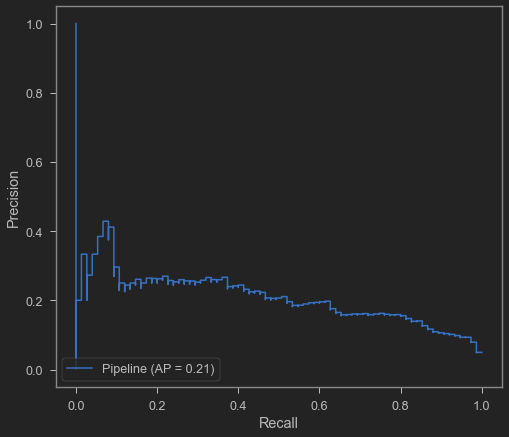

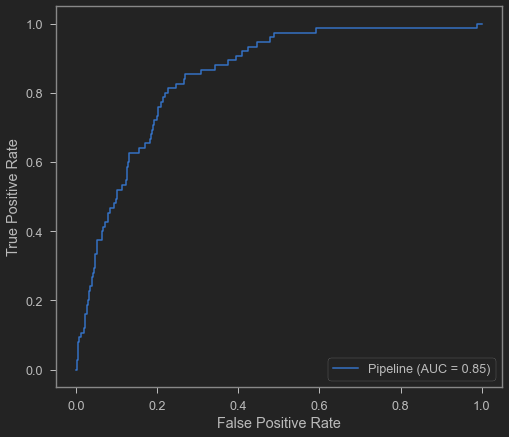

In [131]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

HT ON LOGREG SMOTE WITH SCALING

In [132]:
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', smote),
    ('model', logreg)
])

hyperparam_space =[{
    'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'preprocess__Scaling__Scaling__with_centering' : [True, False],
    'preprocess__Scaling__Scaling__with_scaling' : [True, False],
    'balancing__k_neighbors' : [5, 6, 7, 8, 9, 10]}
]

In [133]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [134]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  0.9196638655462186
best score  {'balancing__k_neighbors': 5, 'model__C': 0.001, 'model__solver': 'liblinear', 'preprocess__Scaling__Scaling__with_centering': True, 'preprocess__Scaling__Scaling__with_scaling': True}


In [135]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.53      0.70      1458
           1       0.09      0.92      0.17        75

    accuracy                           0.55      1533
   macro avg       0.54      0.73      0.43      1533
weighted avg       0.95      0.55      0.67      1533



In [136]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,780,678
1,6,69


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d5537b8b88>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d555b9b408>)

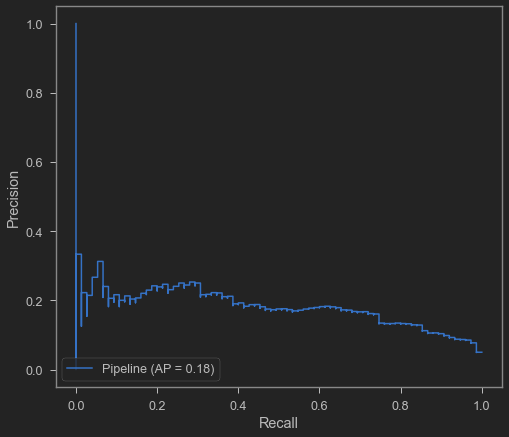

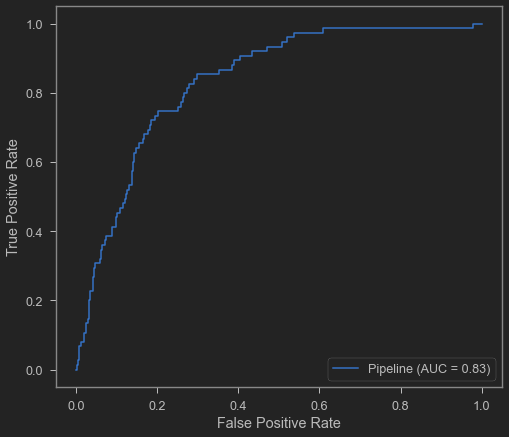

In [137]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

HT ON LOGREG RANDOMOVER WITHOUT SCALING

In [138]:
impute = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean'))
])
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', impute, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [139]:
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomover),
    ('model', logreg)
])

hyperparam_space =[{
    'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
]

In [140]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [141]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  0.7932773109243698
best score  {'model__C': 0.1, 'model__solver': 'newton-cg'}


In [142]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.88      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.79      0.53      1533
weighted avg       0.95      0.72      0.80      1533



In [143]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,1033,425
1,9,66


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d555bda208>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d555bc0288>)

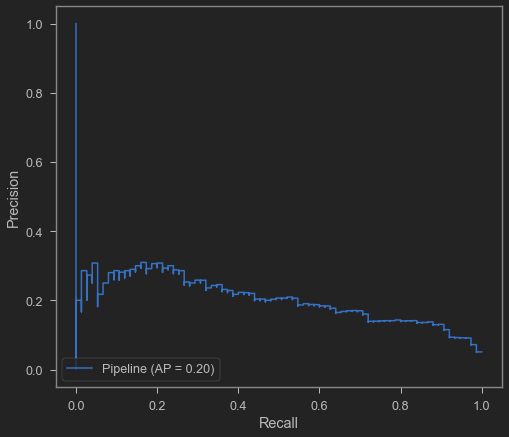

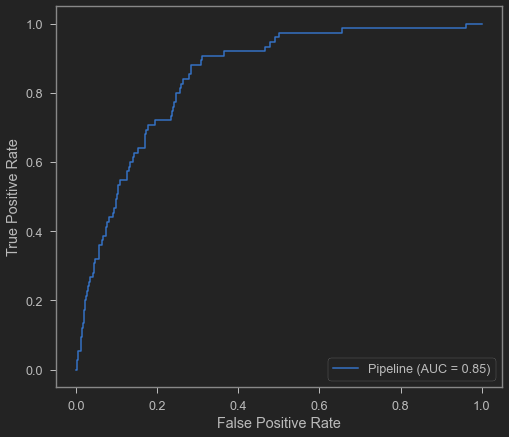

In [144]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

HT ON KNN RANDOMUNDER WITHOUT SCALING

In [145]:
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomunder),
    ('model', knn)
])

hyperparam_space =[{
    'model__n_neighbors':[5, 6, 7, 8, 9, 10], 
    'model__weights' : ['uniform', 'distance']}
]

In [146]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [147]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  0.8275630252100841
best score  {'model__n_neighbors': 5, 'model__weights': 'distance'}


In [148]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1458
           1       0.11      0.84      0.20        75

    accuracy                           0.67      1533
   macro avg       0.55      0.75      0.50      1533
weighted avg       0.94      0.67      0.76      1533



In [149]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,963,495
1,12,63


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d555b65e48>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d555f2c888>)

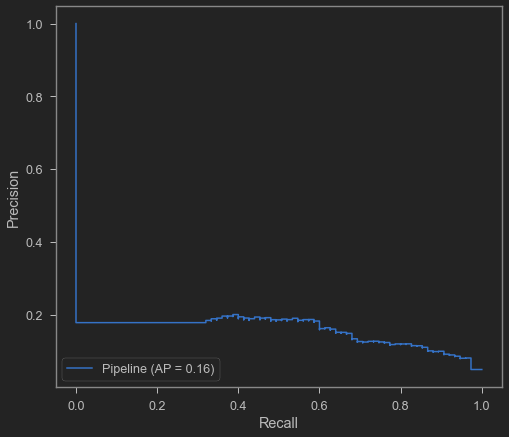

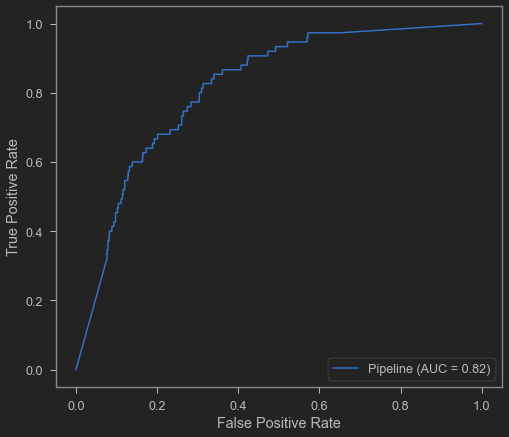

In [150]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

# HYPERPARAMETER PERFORMANCE RESULT

    LOGREG RANDOMUNDER SCALING : 0.99
        params : 'model__C': 0.001, 
                    'model__solver': 'liblinear', 
                    'preprocess__Scaling__Scaling__with_centering': True, 
                    'preprocess__Scaling__Scaling__with_scaling': True
    
    LOGREG SMOTE SCALING : 0.92
        params : 'balancing__k_neighbors': 5, 
                    'model__C': 0.001, 
                    'model__solver': 'liblinear', 
                    'preprocess__Scaling__Scaling__with_centering': True, 
                    'preprocess__Scaling__Scaling__with_scaling': True
    
    LOGREG RANDOMOVER WITHOUT SCALING : 0.88
        params : 'model__C': 0.1, 
                    'model__solver': 'newton-cg'
    
    KNN RANDOMUNDER WITHOUT SCALING : 0.84
        params : 'model__n_neighbors': 5, 
                    'model__weights': 'distance'

# CONCLUSION ON WHAT MODEL AND METHOD TO PICK

    I will be using randomunder with robust scaling using params 
         model__C : 0.001 
         model__solver : liblinear 
         preprocess__Scaling__Scaling__with_centering : True
         preprocess__Scaling__Scaling__with_scaling : True
    with the score of 0.99 on recall
    
    Reason for me to decide why I use this as my predictive model even if the FN is really low
    (in quantity) and very-very high(which means the machine will more often predicts people who's 
    healthy getting a stroke). But that's not a really big deal because the machine just predicts
    that the person MIGHT get a stroke so the prevention would be :
       - eat a healthy diet
       - exercise regularly
       - avoid smoking and drinking too much alcohol
    But of course the worst case scenario would be that the person would be sad and panic, 
    but as how every medical situation goes, the person would be receiving countermeasures
    to prevent this 'false' prediction from happening. So in a much simple explanation would be
    this person is healthier than before.
    
    As for the recall score, I believe this is the best option. No matter how you look at it,
    it is a bad call if the person that's might have stroke but predicted healthy. Because this way,
    the person would 100% get a stroke because there's no proper treatment, the person will keep 
    living the unhealthy life and so end up getting a stroke for real.
    
Source about stroke prevention : https://www.nhs.uk/conditions/stroke/prevention/#:~:text=The%20best%20way%20to%20help,high%20blood%20pressure

# QUICK UPDATE ABOUT TREE

    Eventhough the value decrease by -0.07 between crossvalidation and test predict, the difference isn't that
    bad so I thought I should give it try using hyperparams on it to see if it could give some good result.
    Of course the resampling method I'm going to use would be Nearmiss(because the others are underfitting)
    

In [159]:
impute = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean'))
])
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', impute, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [160]:
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', nearmiss),
    ('model', tree)
])

hyperparam_space =[{
    'model__criterion': ['gini', 'entropy'], 
    'model__splitter' : ['best', 'random'],
    'model__max_depth' : [1, 2, 3, 4],
    'model__min_samples_split' : [2, 3, 4, 5],
    'model__min_samples_leaf' : [1, 2, 3, 4],
    'balancing__n_neighbors' : [3, 4, 5, 6]}
]

In [161]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [162]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  0.5870588235294119
best score  {'balancing__n_neighbors': 6, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__splitter': 'best'}


In [163]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.18      0.29      1458
           1       0.04      0.71      0.08        75

    accuracy                           0.20      1533
   macro avg       0.48      0.44      0.19      1533
weighted avg       0.88      0.20      0.28      1533



In [164]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,256,1202
1,22,53


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d5563b83c8>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d5565dbf08>)

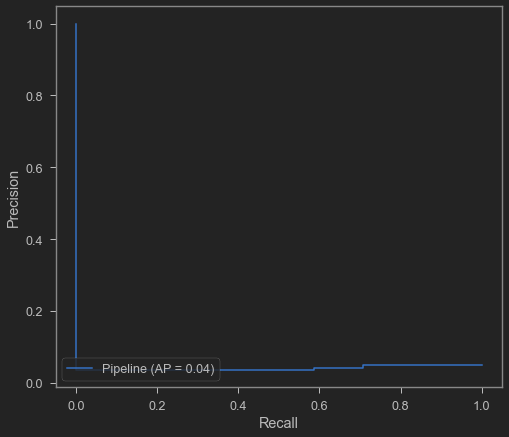

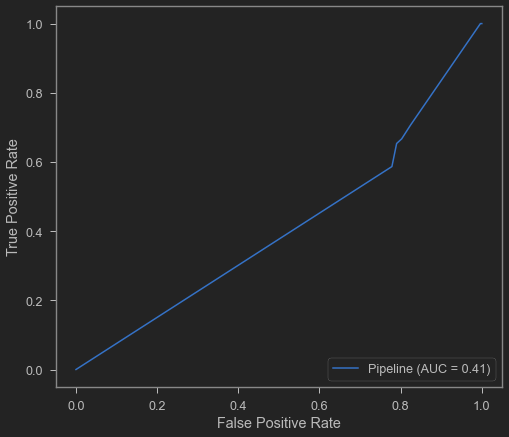

In [165]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

# CONCLUSION FOR TREE

    The result isn't that great even after hyperparams, there's an increase though in performance from
    0.68 to 0.71 (+0.03)

# TESTING SAJA UNTUK RESAMPLING HYPERPARAMS

In [166]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', RobustScaler())
])
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [180]:
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomunder),
    ('model', logreg)
])

hyperparam_space =[{
    'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'balancing' : [randomunder, randomover, smote, nearmiss],
    'preprocess__Scaling__Scaling__with_centering' : [True, False],
    'preprocess__Scaling__Scaling__with_scaling' : [True, False]}
]

In [181]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [182]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  1.0
best score  {'balancing': RandomUnderSampler(random_state=2021), 'model__C': 0.001, 'model__solver': 'liblinear', 'preprocess__Scaling__Scaling__with_centering': True, 'preprocess__Scaling__Scaling__with_scaling': True}


In [183]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.09      0.17      1458
           1       0.05      0.99      0.10        75

    accuracy                           0.14      1533
   macro avg       0.52      0.54      0.14      1533
weighted avg       0.95      0.14      0.17      1533



In [184]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,136,1322
1,1,74


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d5562a7cc8>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d5565938c8>)

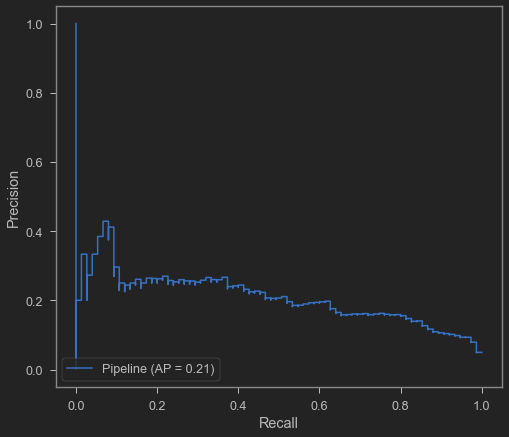

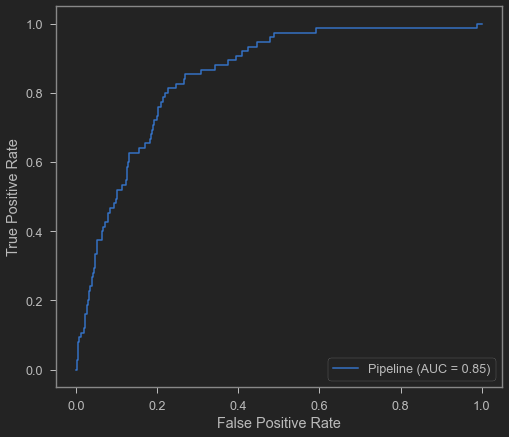

In [185]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

Work as intended, overall the best resampling method would be random-under-sampling